In [1]:
%matplotlib notebook
from nansat import *

In [22]:
# open dataset and crop
n = Nansat('http://www.ifremer.fr/opendap/cerdap1/globcurrent/v2.0/global_012_deg/geostrophic/2014/231/20140819000000-GLOBCURRENT-L4-CURgeo_0m-ALT_OI-v02.0-fv01.0.nc')
n.crop_lonlat([20, 35], [-45, -35])

(1600, 280, 120, 80)

In [23]:
# fetch U,V and lon,lat
u = n['eastward_geostrophic_current_velocity']
v = n['northward_geostrophic_current_velocity']
lon, lat = n.get_geolocation_grids()

In [24]:
from scipy import ndimage
def rungekutta4(x, y, u0, v0, u1, v1, x0, y0, h):
    ''' Integrate velocity field using Runge-Kutta 4th order '''
    # convert grid with initial X (in meters) to columns
    xMin, xMax = float(x.min()), float(x.max())
    x1 = (x0 - xMin) / (xMax - xMin) * (x.shape[1] - 1)

    # convert grid with initial Y (in meters) to rows (reverse)
    yMin, yMax = float(y.min()), float(y.max())
    y1 = (yMax - y0) / (yMax - yMin) * (y.shape[0] - 1)

    # rescale h to be in rows/cols
    dx = float(np.diff(x)[0,0])
    h /= dx

    k1 = h * ndimage.map_coordinates(u0, [y1, x1], order=1, cval=np.nan)
    l1 =-h * ndimage.map_coordinates(v0, [y1, x1], order=1, cval=np.nan)

    k2 = h * ndimage.map_coordinates((u0 + u1) / 2, [y1 + l1 / 2, x1 + k1 / 2], order=1, cval=np.nan)
    l2 =-h * ndimage.map_coordinates((v0 + v1) / 2, [y1 + l1 / 2, x1 + k1 / 2], order=1, cval=np.nan)

    k3 = h * ndimage.map_coordinates((u0 + u1) / 2, [y1 + l2 / 2, x1 + k2 / 2], order=1, cval=np.nan)
    l3 =-h * ndimage.map_coordinates((v0 + v1) / 2, [y1 + l2 / 2, x1 + k2 / 2], order=1, cval=np.nan)

    k4 = h * ndimage.map_coordinates(u1, [y1 + l3, x1 + k3], order=1, cval=np.nan)
    l4 =-h * ndimage.map_coordinates(v1, [y1 + l3, x1 + k3], order=1, cval=np.nan)

    x5 = x1 + (k1 + 2 * k2 + 2 * k3 + k4) / 6
    y5 = y1 + (l1 + 2 * l2 + 2 * l3 + l4) / 6

    # convert rows/cols back to meters
    xOut = x5 / (x.shape[1] - 1) * (xMax - xMin) + xMin
    yOut = yMax - y5 / (x.shape[0] - 1) * (yMax - yMin)

    return xOut, yOut

NMAX = 100.
def run_rk4(xgrd, ygrd, u, v, h, xx, yy, n=0):
    if (xx[-1] > xgrd.max() or
        xx[-1] < xgrd.min() or
        yy[-1] > ygrd.max() or
        yy[-1] < ygrd.min() or
        n > NMAX):
        return xx, yy
    #print xx, yy, n
    x1, y1 = rungekutta4(xgrd, ygrd, u, v, u, v, np.array([xx[-1]]), np.array([yy[-1]]), h)
    xx.append(x1[0])
    yy.append(y1[0])
    return run_rk4(xgrd, ygrd, u, v, h, xx, yy, n+1)

<IPython.core.display.Javascript object>


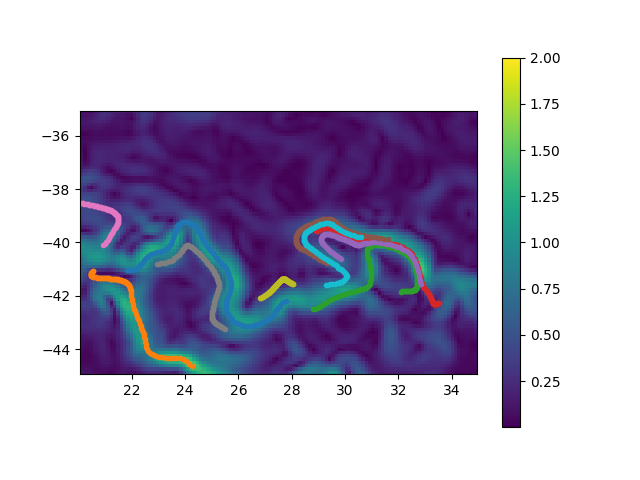

None None


In [25]:
h = 0.1
xgrd, ygrd = lon.copy(), lat.copy()
xx, yy = None, None

# interactive animation (local Jupyter-notebook)
fig = plt.figure()
ax1 = fig.add_subplot(111)

def click(event):
    global x0, y0, xx, yy
    if event.button==1 and event.inaxes:#select initial conditions pressing left mouse button 
        x0,y0 = event.xdata, event.ydata
        print x0, y0
        xx,yy = run_rk4(xgrd, ygrd, u, -v, h, [x0], [y0])
        ax1.plot(xx, yy, '.-')
        fig.canvas.draw()

img1 = ax1.imshow(np.hypot(u,v), extent=[xgrd.min(), xgrd.max(), ygrd.min(), ygrd.max()], vmax=2);
plt.colorbar(img1)
plt.connect('button_press_event', click)
plt.show()
print xx, yy